<a href="https://colab.research.google.com/github/thaovivng/CustomerSegmentationUsingTheMeanShiftAlgorithm/blob/main/UEHMachineLearning_FinalProject_MeanShift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **READ DATA AND IMPORT LIBRARIES**

In [1]:
!pip install ipython-autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 6.3 MB/s eta 0:00:00


In [2]:
#https://drive.google.com/file/d/1YtnCCOgOffQjEjrT5qIdl2tHUOIkMZYY/view?usp=sharing
!gdown 1YtnCCOgOffQjEjrT5qIdl2tHUOIkMZYY

Downloading...
From: https://drive.google.com/uc?id=1YtnCCOgOffQjEjrT5qIdl2tHUOIkMZYY
To: /content/Customers.csv
100% 74.3k/74.3k [00:00<00:00, 7.38MB/s]


## Kết nối Google Drive


In [3]:
'''
from google.colab import drive
drive.mount('/content/gdrive', force_remount = True)
folder = '/content/gdrive/My Drive/Machine Learning'
'''

"\nfrom google.colab import drive\ndrive.mount('/content/gdrive', force_remount = True)\nfolder = '/content/gdrive/My Drive/Machine Learning'\n"

In [4]:
! mkdir figs

In [5]:
#df = pd.read_csv(folder + '/Customers.csv')

In [6]:
import pandas               as pd
import numpy                as np
import matplotlib.pyplot    as plt
import seaborn              as sns
import scipy                as scp
import warnings
warnings.filterwarnings('ignore') # tắt những cảnh báo
##############################################
from sklearn.preprocessing  import LabelEncoder
from sklearn.cluster        import MeanShift, estimate_bandwidth

In [7]:
df = pd.read_csv('/content/Customers.csv')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              2000 non-null   int64 
 1   Gender                  2000 non-null   object
 2   Age                     2000 non-null   int64 
 3   Annual Income ($)       2000 non-null   int64 
 4   Spending Score (1-100)  2000 non-null   int64 
 5   Profession              1965 non-null   object
 6   Work Experience         2000 non-null   int64 
 7   Family Size             2000 non-null   int64 
dtypes: int64(6), object(2)
memory usage: 125.1+ KB


In [9]:
num = df.select_dtypes(exclude='O')
cat = df.select_dtypes(include='O')
print("Numerical Columns:")
stt = 1
for col in num.columns:
  print(f'{stt})','{:<25}'.format(col),f'({len(df[col].unique())} values):',f'[{min(df[col])} - {max(df[col])}]')
  stt += 1
print('')
print("Categorical Columns:")
stt = 1
for col in cat.columns:
  print(f'{stt})','{:<10}'.format(col),f'({len(df[col].unique())} values):',f'{df[col].unique()}')
  stt += 1

Numerical Columns:
1) CustomerID                (2000 values): [1 - 2000]
2) Age                       (100 values): [0 - 99]
3) Annual Income ($)         (1786 values): [0 - 189974]
4) Spending Score (1-100)    (101 values): [0 - 100]
5) Work Experience           (18 values): [0 - 17]
6) Family Size               (9 values): [1 - 9]

Categorical Columns:
1) Gender     (2 values): ['Male' 'Female']
2) Profession (10 values): ['Healthcare' 'Engineer' 'Lawyer' 'Entertainment' 'Artist' 'Executive'
 'Doctor' 'Homemaker' 'Marketing' nan]


In [10]:
print(df.head())
print('-'*80)
print(df.tail())

   CustomerID  Gender  Age  Annual Income ($)  Spending Score (1-100)  \
0           1    Male   19              15000                      39   
1           2    Male   21              35000                      81   
2           3  Female   20              86000                       6   
3           4  Female   23              59000                      77   
4           5  Female   31              38000                      40   

      Profession  Work Experience  Family Size  
0     Healthcare                1            4  
1       Engineer                3            3  
2       Engineer                1            1  
3         Lawyer                0            2  
4  Entertainment                2            6  
--------------------------------------------------------------------------------
      CustomerID  Gender  Age  Annual Income ($)  Spending Score (1-100)  \
1995        1996  Female   71             184387                      40   
1996        1997  Female   91     

# **Preprocessing**

## Chỉnh sửa các cột

In [11]:
#Xóa cột CustomerID
df = df.drop(['CustomerID'], axis = 1)

In [12]:
#Thay đổi tên cột
df.rename(columns={
    'Annual Income ($)'        : 'Annual Income',
    'Spending Score (1-100)'       : 'Spending Score'
}, inplace=True)

##Xử lý missing data

In [13]:
df.isna().sum()

Gender              0
Age                 0
Annual Income       0
Spending Score      0
Profession         35
Work Experience     0
Family Size         0
dtype: int64

In [14]:
#Xóa dòng có missing data
df.dropna(inplace=True)

In [15]:
#Xem lại dữ liệu sau khi xóa các dòng có missing data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1965 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Gender           1965 non-null   object
 1   Age              1965 non-null   int64 
 2   Annual Income    1965 non-null   int64 
 3   Spending Score   1965 non-null   int64 
 4   Profession       1965 non-null   object
 5   Work Experience  1965 non-null   int64 
 6   Family Size      1965 non-null   int64 
dtypes: int64(5), object(2)
memory usage: 122.8+ KB


##Xử lý outliers

In [16]:
# Phân loại cột có kiểu dữ liệu số và chữ
num = df.select_dtypes(exclude='O')
cat = df.select_dtypes(include='O')

print(num.columns, num.shape[1])
print(cat.columns, cat.shape[1])

Index(['Age', 'Annual Income', 'Spending Score', 'Work Experience',
       'Family Size'],
      dtype='object') 5
Index(['Gender', 'Profession'], dtype='object') 2


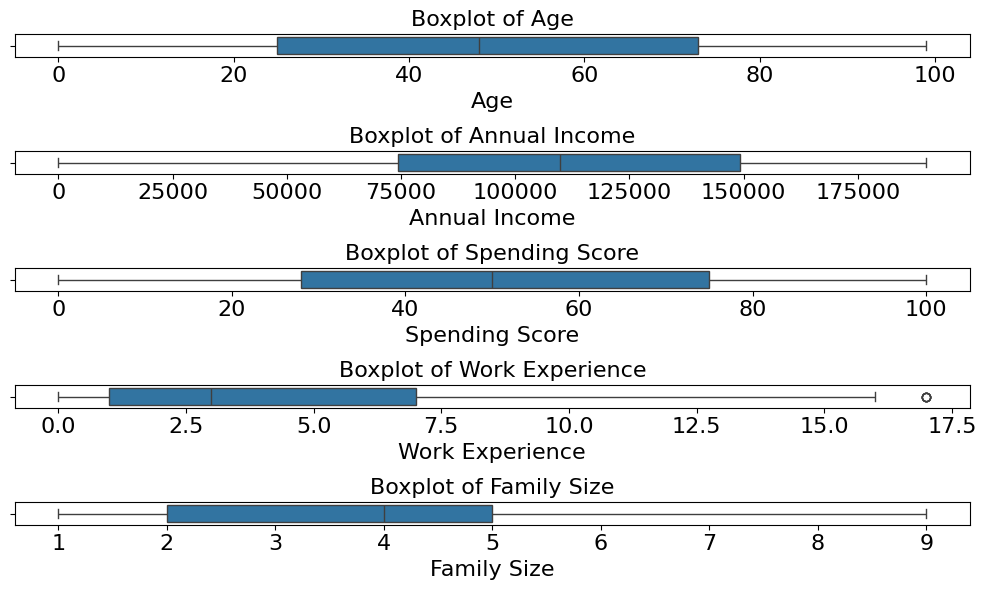

In [17]:
#Dùng boxplot kiểm tra outliers
fig, axs = plt.subplots(len(num.columns), figsize=(10, 1.2*len(num.columns)))
for i, column in enumerate(num.columns):
    sns.boxplot(x=df[column], ax=axs[i])
    axs[i].set_title(f'Boxplot of {column}', fontsize =16)
    axs[i].set_xlabel(column, fontsize=16)
    axs[i].tick_params(axis='x', labelsize=16)

plt.tight_layout()
plt.savefig(f"figs/Boxplot num cols.pdf")
plt.show()

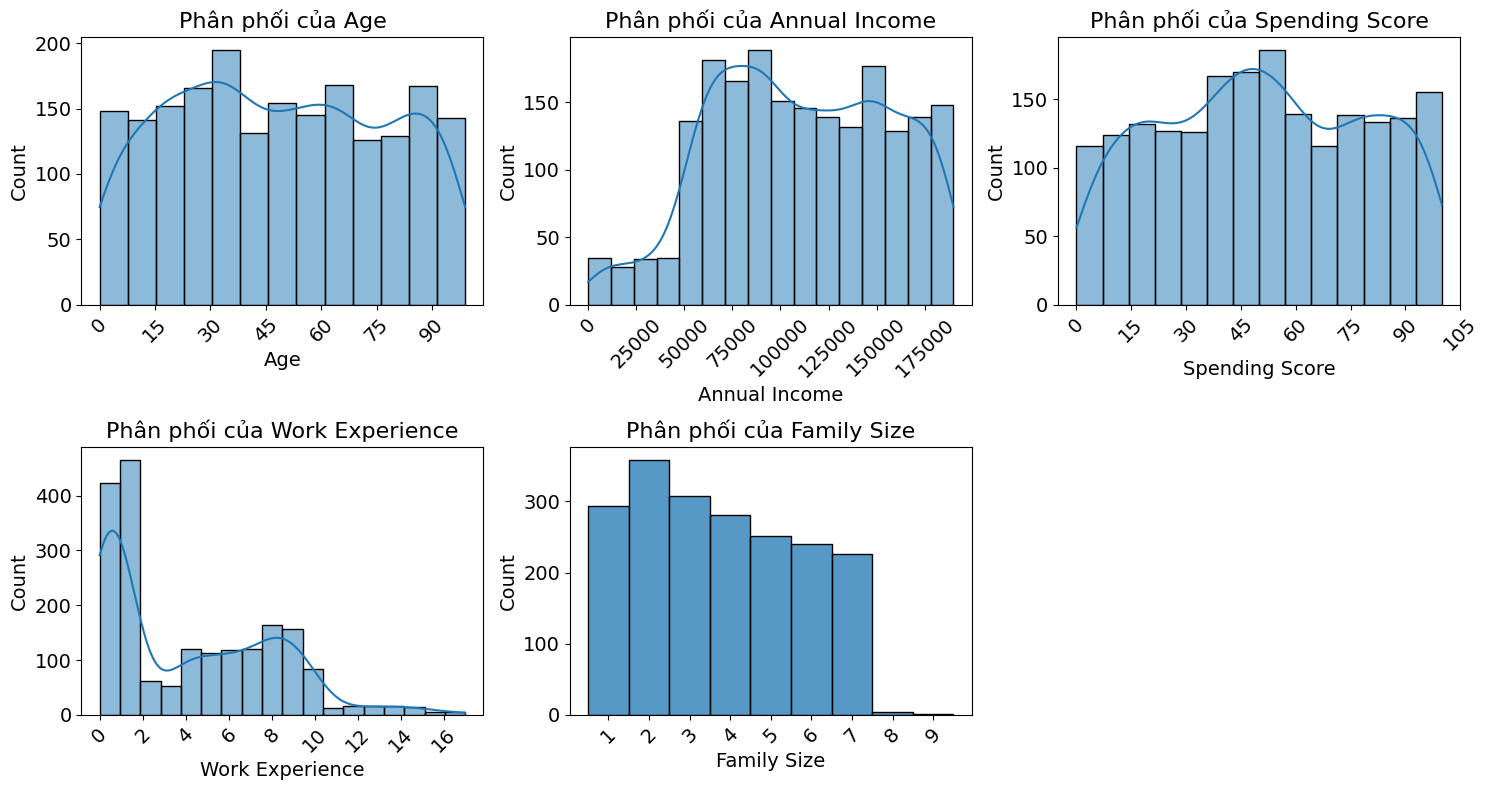

In [18]:
# Xem phân phối của dữ liệu
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import math

num_cols = len(num.columns)
num_rows = math.ceil(num_cols / 3)

fig, axs = plt.subplots(num_rows, 3, figsize=(15, num_rows*4))

for i, col in enumerate(num.columns):
    if col == 'Family Size':
        kde = False
        discrete  = True
    else:
        kde = True
        discrete  = False

    ax = axs[i//3, i%3]
    sns.histplot(data=num, x=col, kde=kde, ax=ax, discrete=discrete)
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    ax.set_title(f'Phân phối của {col}', fontsize=16)
    ax.set_xlabel(ax.get_xlabel(), fontsize=14)
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)

    ax.tick_params(axis='x', labelsize=14,rotation=45)
    ax.tick_params(axis='y', labelsize=14)

    ax.grid(False)

# Xóa các subplot trống
if num_cols % 3 != 0:
    for i in range(num_cols, num_rows*3):
        fig.delaxes(axs.flatten()[i])

plt.tight_layout()

plt.savefig('figs/histograms.pdf')
plt.show()

In [19]:
#IQR
def detect_outliers_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 *IQR))]
    return outliers

for column in num.columns:
  outliers = detect_outliers_iqr(num[column])
  print(f"Outliers cột {column}: {np.sort(outliers.unique())} - Số lượng: {len(outliers)} ({(len(outliers)/ len(num[column]))* 100:.2f}%)")

Outliers cột Age: [] - Số lượng: 0 (0.00%)
Outliers cột Annual Income: [] - Số lượng: 0 (0.00%)
Outliers cột Spending Score: [] - Số lượng: 0 (0.00%)
Outliers cột Work Experience: [17] - Số lượng: 5 (0.25%)
Outliers cột Family Size: [] - Số lượng: 0 (0.00%)


In [20]:
#Xem thông tin các dòng có chứa outliers
df[df['Work Experience']==17]

,Gender,Age,Annual Income,Spending Score,Profession,Work Experience,Family Size
392,Male,21,119116,30,Artist,17,4
405,Female,65,119889,11,Artist,17,6
473,Male,20,130813,92,Artist,17,5
566,Female,19,180331,14,Artist,17,5
603,Female,91,69720,78,Lawyer,17,6


In [21]:
#Nhận thấy sự bất thường nằm ở những người có df['Age']-df['Year'] nhỏ. VD: mới 19 tuổi đã đi làm được 17 năm
#Xem những người bắt đầu đi làm khi dưới 16 tuổi
df[df['Age']-df['Work Experience']<16]

,Gender,Age,Annual Income,Spending Score,Profession,Work Experience,Family Size
33,Male,18,62000,92,Homemaker,9,7
39,Female,20,69000,75,Artist,8,2
47,Female,27,71000,47,Healthcare,12,1
61,Male,19,50000,55,Artist,9,2
95,Male,24,80000,52,Artist,10,1
...,...,...,...,...,...,...,...
1979,Male,0,165321,93,Doctor,8,1
1980,Female,10,86925,76,Artist,7,2
1984,Female,2,153622,51,Lawyer,6,6
1986,Female,4,68094,61,Doctor,4,7


In [22]:
#Loại ra những người bắt đầu đi làm khi dưới 16 tuổi
df.drop(df[df['Age']-df['Work Experience']<16].index,axis = 0,inplace=True)

# **EDA**

In [23]:
df.describe()

,Age,Annual Income,Spending Score,Work Experience,Family Size
count,1592.000000,1592.000000,1592.000000,1592.000000,1592.000000
mean,58.002513,108516.331030,50.558417,3.800879,3.752513
std,23.433713,46193.912167,27.707943,3.778756,1.956229
min,16.000000,0.000000,0.000000,0.000000,1.000000
25%,37.000000,72399.250000,28.000000,1.000000,2.000000
50%,58.000000,105278.500000,50.000000,2.000000,4.000000
75%,79.000000,147283.750000,74.000000,7.000000,5.000000
max,99.000000,189974.000000,100.000000,17.000000,9.000000


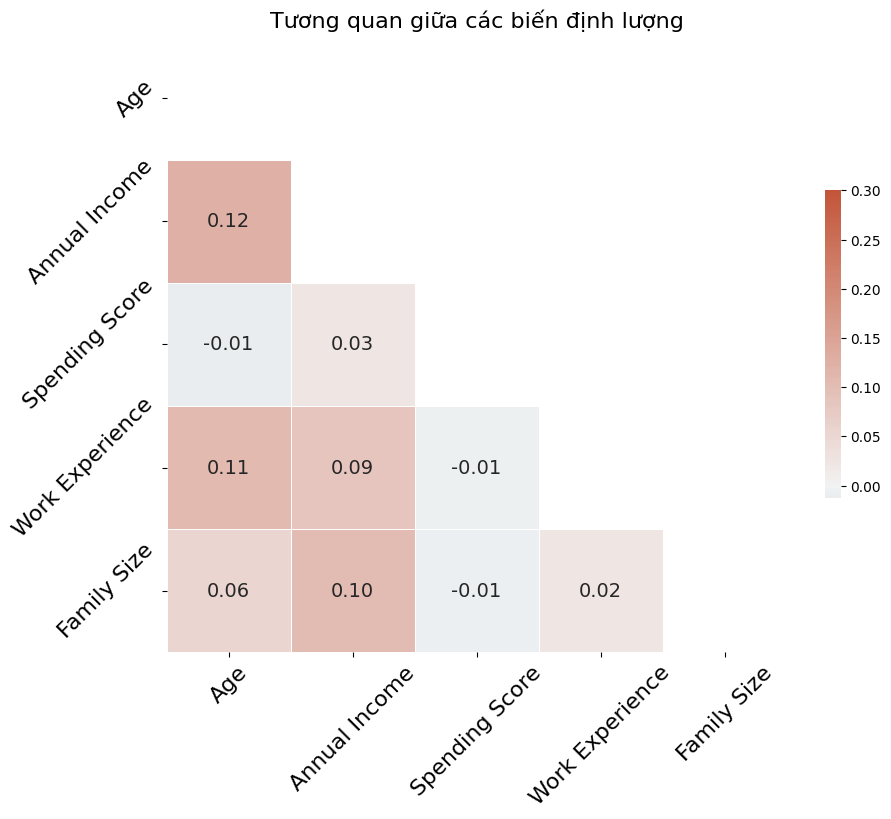

In [24]:
# Tương quan giữa các biến định lượng

numeric_cols = [col for col in df.columns if pd.api.types.is_numeric_dtype(df[col])]
df_numeric = df[numeric_cols]

corr_matrix = df_numeric.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Tạo heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix,
            mask=mask,
            cmap=cmap,
            vmax=.3,
            center=0,
            annot=True,
            fmt=".2f",
            linewidths=.5,
            cbar_kws={"shrink": .5},
            annot_kws={"size": 14})
plt.xticks(fontsize =16,rotation=45)
plt.yticks(fontsize =16,rotation=45)
plt.title('Tương quan giữa các biến định lượng',fontsize =16)
plt.savefig('figs/Tương quan giữa các biến định lượng.pdf')
plt.show()

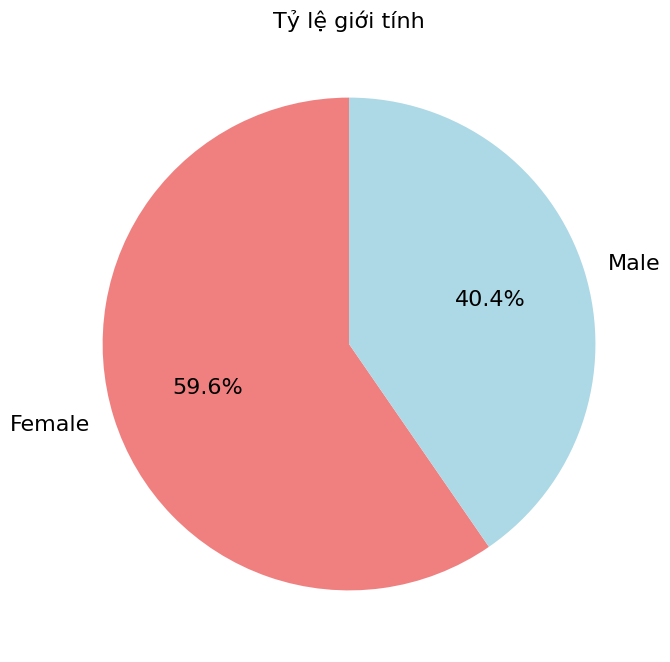

In [25]:
# Giới tính nào chiếm tỷ lệ lớn nhất?

gender_count = df['Gender'].value_counts()
custom_colors = ['lightcoral','lightblue']

plt.figure(figsize=(8, 8))
plt.pie(gender_count, labels=gender_count.index, autopct='%1.1f%%', startangle=90, colors=custom_colors)
plt.title("Tỷ lệ giới tính", fontsize=16)

for text in plt.gca().texts:
    text.set_fontsize(16)

plt.savefig('figs/gender_pie.pdf')
plt.show()

╒═══════════════╤════════════╕
│ Nghề nghiệp   │   Số lượng │
╞═══════════════╪════════════╡
│ Artist        │        494 │
├───────────────┼────────────┤
│ Healthcare    │        273 │
├───────────────┼────────────┤
│ Entertainment │        193 │
├───────────────┼────────────┤
│ Engineer      │        156 │
├───────────────┼────────────┤
│ Doctor        │        126 │
├───────────────┼────────────┤
│ Executive     │        123 │
├───────────────┼────────────┤
│ Lawyer        │        115 │
├───────────────┼────────────┤
│ Marketing     │         67 │
├───────────────┼────────────┤
│ Homemaker     │         45 │
╘═══════════════╧════════════╛


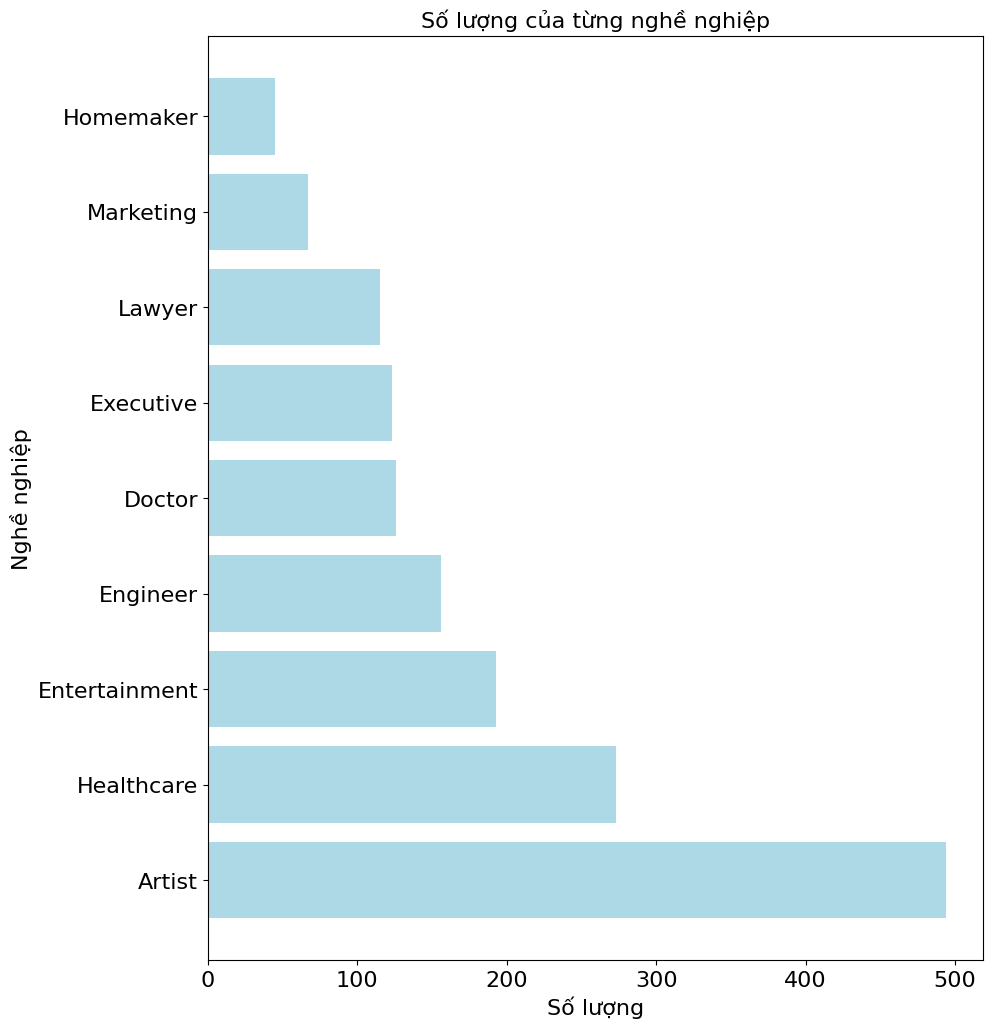

In [26]:
# Nghề nghiệp nào có số lượng lớn nhất?
from tabulate import tabulate
# Tính tỷ lệ của mỗi nghề nghiệp
profession_counts = df['Profession'].value_counts()

# Tạo bảng tabulate
table = tabulate(profession_counts.reset_index(), headers=['Nghề nghiệp', 'Số lượng'], tablefmt='fancy_grid', showindex=False)

print(table)

# Tạo biểu đồ
plt.figure(figsize=(10, 12))
plt.barh(profession_counts.index, profession_counts, color='lightblue')
plt.title('Số lượng của từng nghề nghiệp',fontsize=16)
plt.xlabel('Số lượng',fontsize=16)
plt.ylabel('Nghề nghiệp',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('figs/Số lượng của từng nghề nghiệp.pdf')
plt.show()

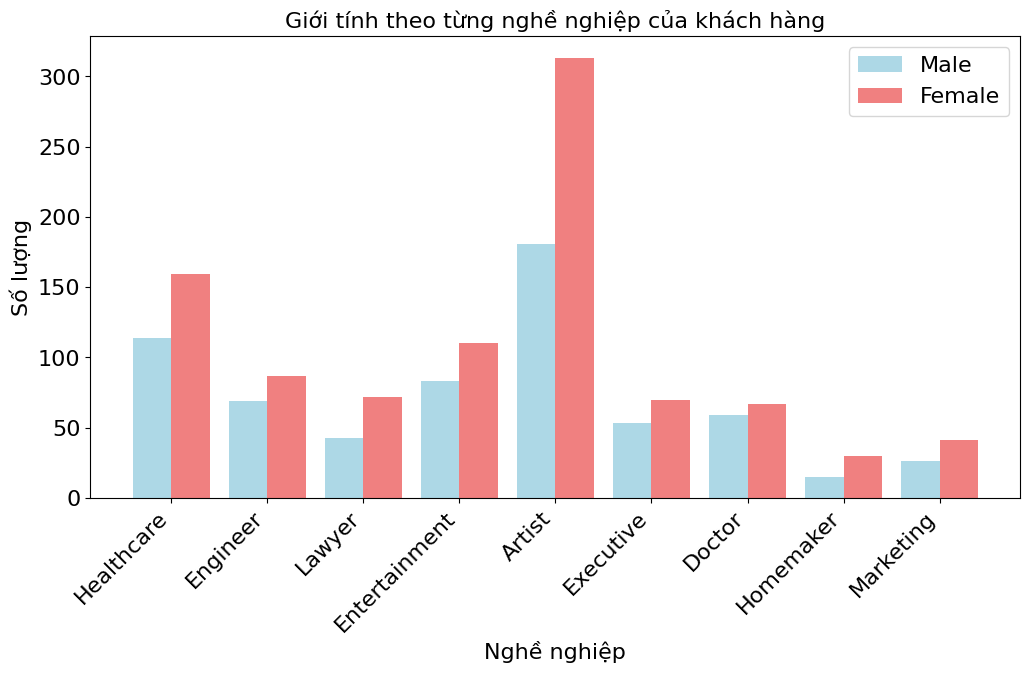

In [27]:
# Sự phân bố nghề nghiệp giữa các giới tính khác nhau như thế nào?
custom_colors = {'Male': 'lightblue', 'Female': 'lightcoral'}

professions = df['Profession'].unique()
bar_width = 0.4
bar_positions = np.arange(len(professions))

fig, ax = plt.subplots(figsize=(12, 6))

for i, gender in enumerate(custom_colors):
    gender_data = df[df['Gender'] == gender]
    gender_counts = gender_data['Profession'].value_counts()

    bars = ax.bar(
        bar_positions + i * bar_width,
        [gender_counts.get(profession, 0) for profession in professions],
        bar_width,
        label=gender,
        color=custom_colors[gender],
    )
ax.set_xticks(bar_positions + bar_width / 2)
ax.set_xticklabels(professions, rotation=45, ha='right',fontsize=16)
ax.set_xticklabels(professions)
ax.tick_params(axis='y', labelsize=16)
ax.set_xlabel('Nghề nghiệp',fontsize=16)
ax.set_ylabel('Số lượng',fontsize=16)
ax.set_title('Giới tính theo từng nghề nghiệp của khách hàng',fontsize=16)
ax.legend(fontsize=16)
plt.savefig('figs/Giới tính theo từng nghề nghiệp của khách hàng.pdf')

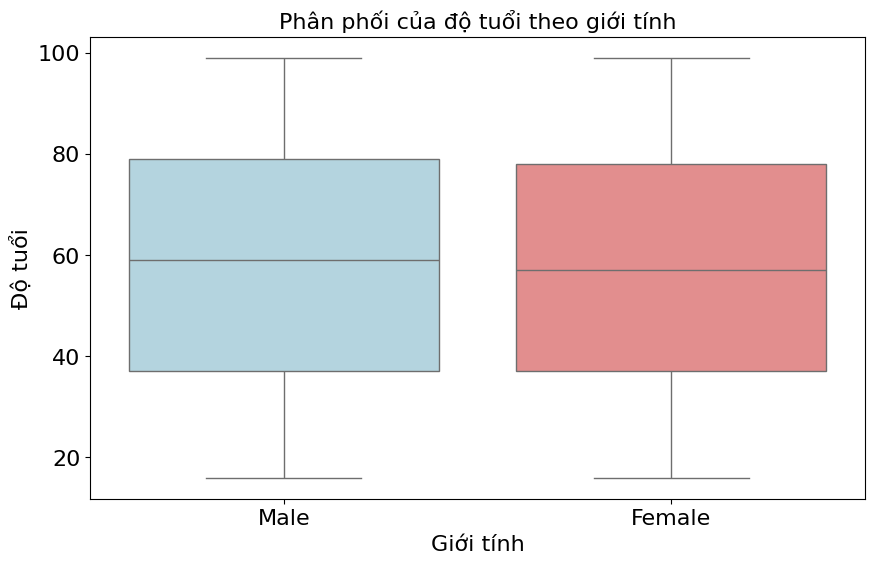

In [28]:
# Phân phối của độ tuổi khách hàng theo giới tính
plt.figure(figsize=(10, 6))
custom_colors = ['lightblue','lightcoral']
sns.boxplot(x='Gender', y='Age', data=df, palette=custom_colors)
plt.title('Phân phối của độ tuổi theo giới tính',fontsize=16)
plt.xlabel('Giới tính',fontsize=16)
plt.ylabel('Độ tuổi',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.savefig('Phân phối của độ tuổi theo giới tính.pdf')
plt.show()

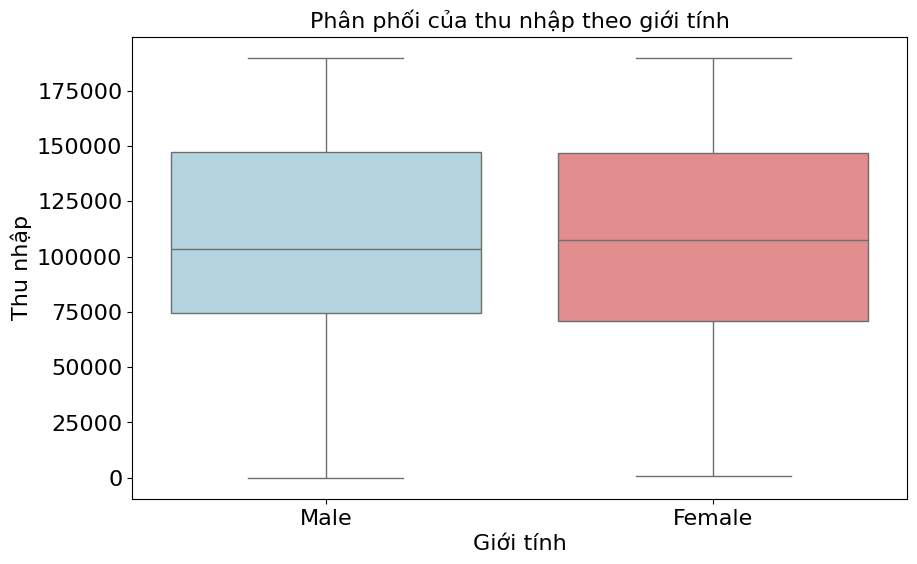

In [29]:
# Phân phối của thu nhập theo giới tính
plt.figure(figsize=(10, 6))
custom_colors = ['lightblue','lightcoral']
sns.boxplot(x='Gender', y='Annual Income', data=df, palette=custom_colors)
plt.title('Phân phối của thu nhập theo giới tính',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Giới tính',fontsize=16)
plt.ylabel('Thu nhập',fontsize=16)
plt.savefig('figs/Phân phối của thu nhập theo giới tính.pdf')
plt.show()

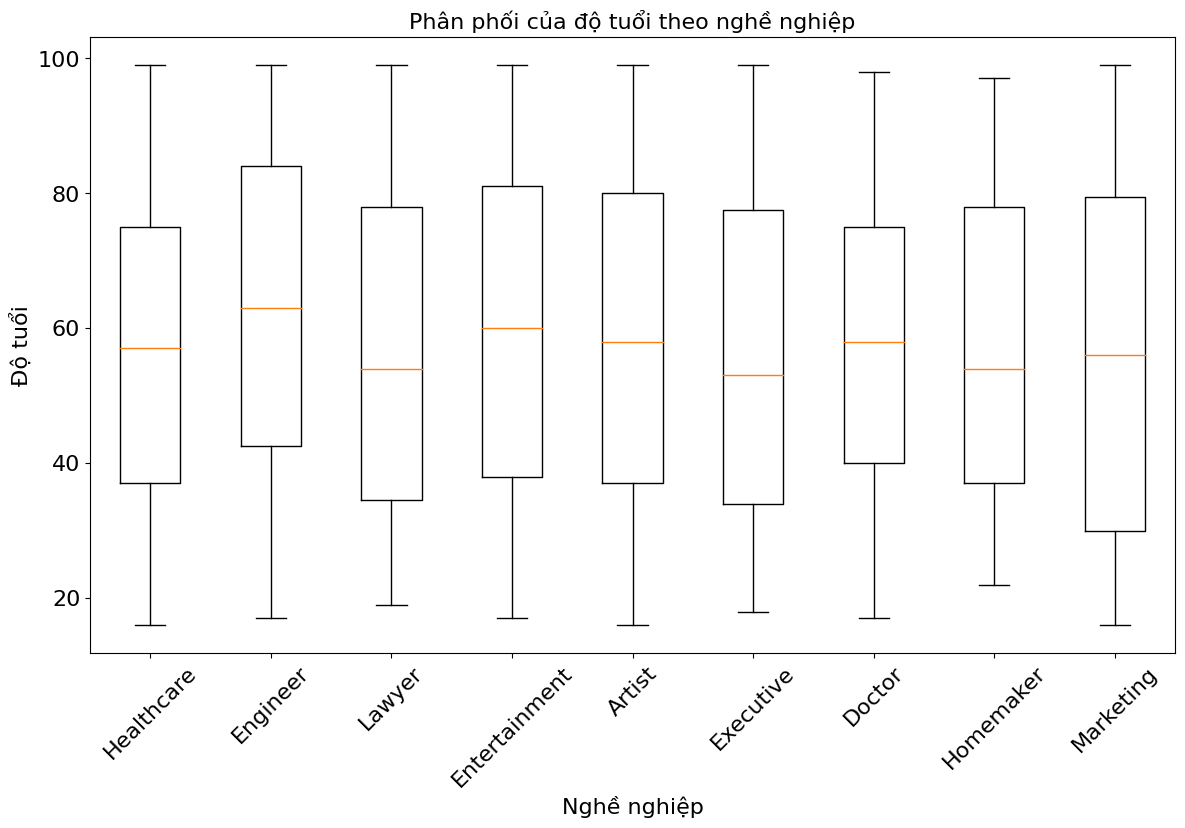

In [30]:
# Phân phối của độ tuổi theo từng nghề nghiệp

plt.figure(figsize=(14, 8))
plt.boxplot([df[df['Profession'] == profession]['Age'] for profession in df['Profession'].unique()],
            labels=df['Profession'].unique())
plt.title('Phân phối của độ tuổi theo nghề nghiệp',fontsize=16)
plt.xlabel('Nghề nghiệp',fontsize=16)
plt.ylabel('Độ tuổi',fontsize=16)
plt.xticks(fontsize=16,rotation=45)
plt.yticks(fontsize=16)
plt.savefig("figs/Phân phối của độ tuổi theo nghề nghiệp.pdf")
plt.show()

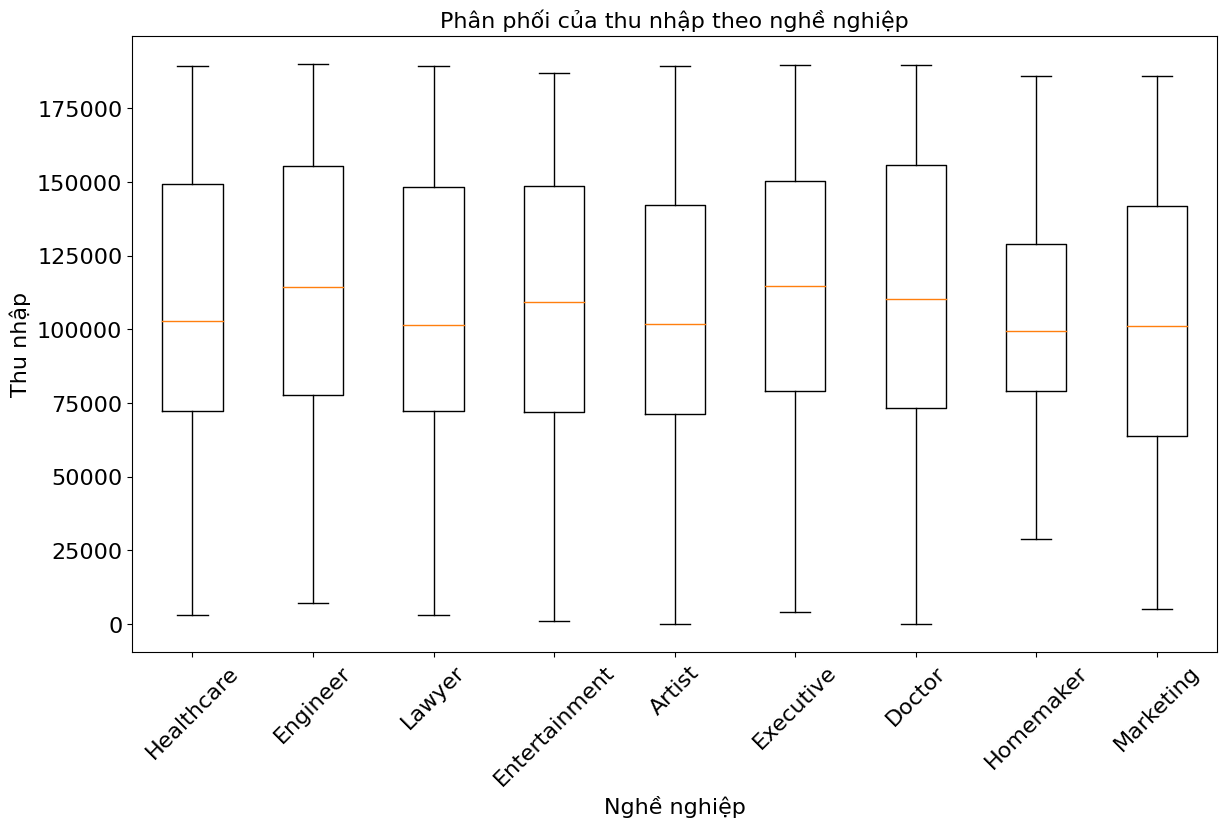

In [31]:
# Phân phối của thu nhập theo từng nghề nghiệp

plt.figure(figsize=(14, 8))
plt.boxplot([df[df['Profession'] == profession]['Annual Income'] for profession in df['Profession'].unique()],
            labels=df['Profession'].unique())
plt.title('Phân phối của thu nhập theo nghề nghiệp',fontsize=16)
plt.xticks(fontsize=16,rotation=45)
plt.yticks(fontsize=16)
plt.xlabel('Nghề nghiệp',fontsize=16)
plt.ylabel('Thu nhập',fontsize=16)
plt.savefig('figs/Phân phối của thu nhập theo nghề nghiệp.pdf')
plt.show()

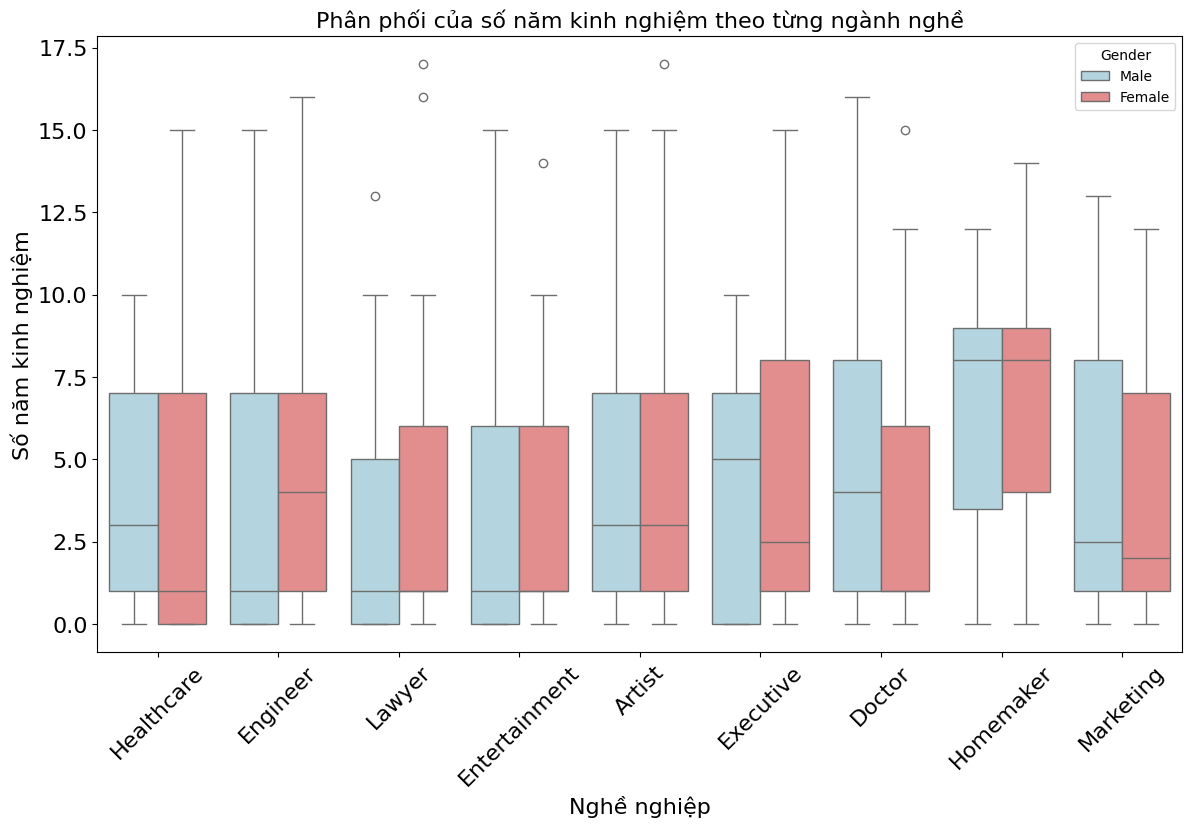

In [32]:
# Phân phối của số năm kinh nghiệm theo từng ngành nghề

plt.figure(figsize=(14, 8))
sns.boxplot(x='Profession', y='Work Experience', hue='Gender', data=df, palette={'Male': 'lightblue', 'Female': 'lightcoral'})
plt.title('Phân phối của số năm kinh nghiệm theo từng ngành nghề',fontsize=16)
plt.xlabel('Nghề nghiệp',fontsize=16)
plt.ylabel('Số năm kinh nghiệm',fontsize=16)
plt.xticks(fontsize=16,rotation=45)
plt.yticks(fontsize=16)
plt.savefig('figs/Phân phối của số năm kinh nghiệm theo từng ngành nghề.pdf')
plt.show()

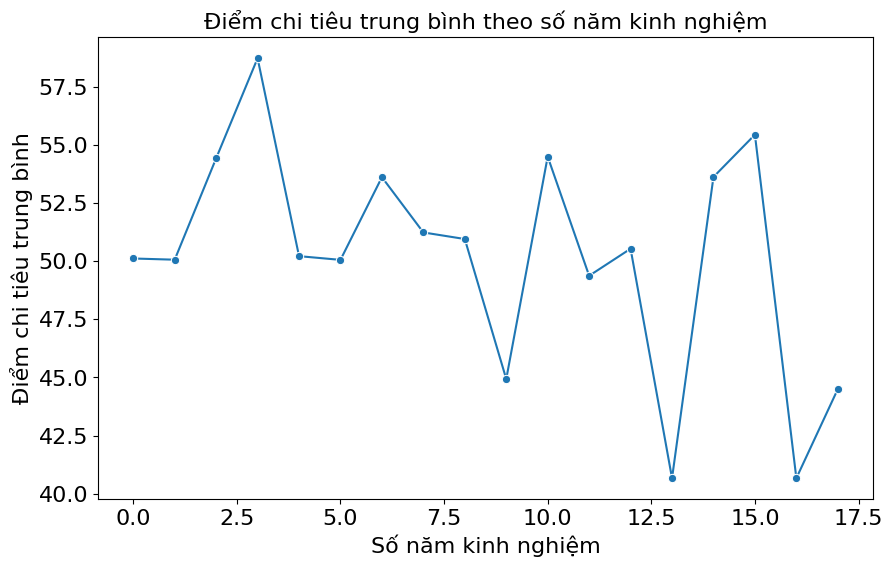

In [33]:
# Xu hướng chi tiêu có dựa vào số năm kinh nghiệm không?

# Tính giá trị trung bình của Spending Score theo Work Experience
avg_spending_by_experience = df.groupby('Work Experience')['Spending Score'].mean().reset_index()

# Tạo biểu đồ đường với seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(x='Work Experience', y='Spending Score', data=avg_spending_by_experience, marker='o')
plt.title('Điểm chi tiêu trung bình theo số năm kinh nghiệm',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Số năm kinh nghiệm',fontsize=16)
plt.ylabel('Điểm chi tiêu trung bình',fontsize=16)
plt.savefig('figs/Điểm chi tiêu trung bình theo số năm kinh nghiệm.pdf')
plt.show()

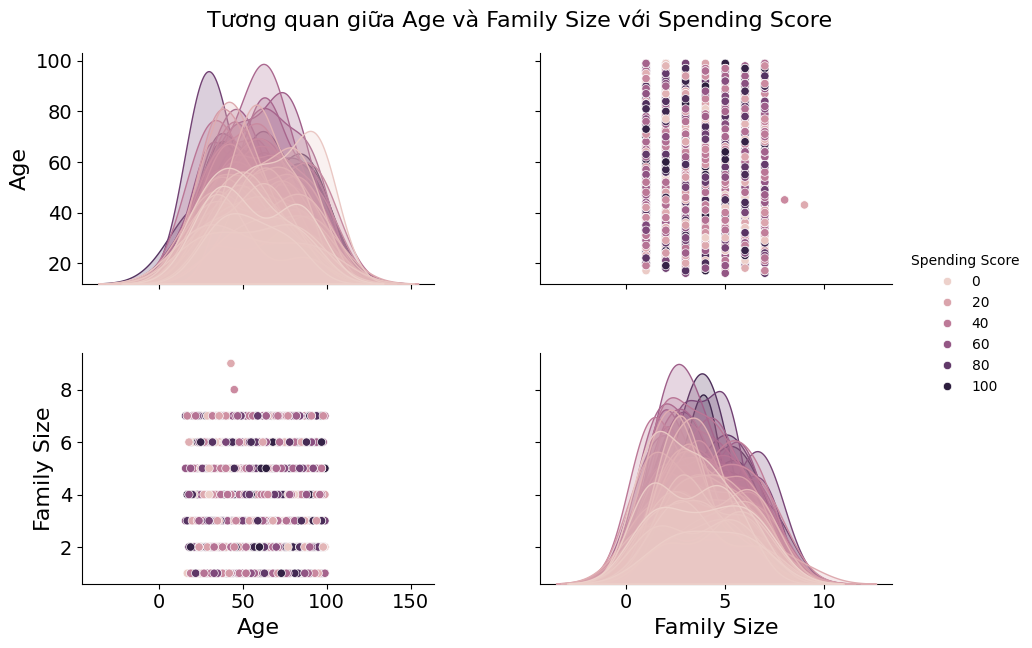

In [34]:
pairplot = sns.pairplot(df, vars=['Age', 'Family Size'], hue='Spending Score', height=3, aspect=1.5)

plt.subplots_adjust(wspace=0.3, hspace=0.3)

for ax in pairplot.axes.flatten():
    ax.tick_params(labelsize=14)
    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)

pairplot.fig.suptitle('Tương quan giữa Age và Family Size với Spending Score', y=1.05, fontsize=16)
plt.savefig('figs/Tương quan giữa Age và Family Size với Spending Score.pdf')
plt.show()

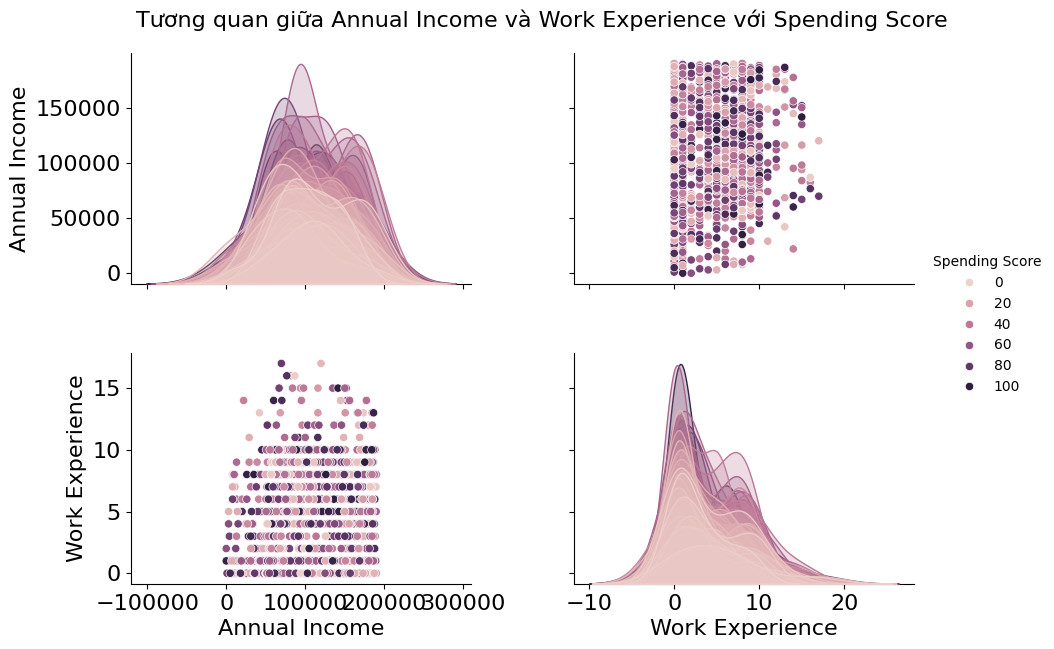

In [35]:
pairplot = sns.pairplot(df, vars=['Annual Income', 'Work Experience'], hue='Spending Score', height=3, aspect=1.5)

plt.subplots_adjust(wspace=0.3, hspace=0.3)

for ax in pairplot.axes.flatten():
    ax.tick_params(labelsize=16)

    ax.set_xlabel(ax.get_xlabel(), fontsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=16)

pairplot.fig.suptitle('Tương quan giữa Annual Income và Work Experience với Spending Score', y=1.05, fontsize=16)
plt.savefig('figs/Tương quan giữa Annual Income và Work Experience với Spending Score.pdf')
plt.show()

# **Machine Learning**

## Chỉnh dạng dữ liệu

In [36]:
#Label Encoding
label_encoder = LabelEncoder()

df['Gender'] = label_encoder.fit_transform(df['Gender'])
df['Profession'] = label_encoder.fit_transform(df['Profession'])

In [37]:
#Chuyển income về thang k$
df['Annual Income'] = df['Annual Income']/1000

In [38]:
df.head()

,Gender,Age,Annual Income,Spending Score,Profession,Work Experience,Family Size
0,1,19,15.0,39,5,1,4
1,1,21,35.0,81,2,3,3
2,0,20,86.0,6,2,1,1
3,0,23,59.0,77,7,0,2
4,0,31,38.0,40,3,2,6


##PCA

In [39]:
from sklearn.decomposition   import PCA

In [40]:
nb_features = 7

In [41]:
## Áp dụng PCA (chưa xác định k --> giữ nguyên số chiều)
pca = PCA().fit(df)

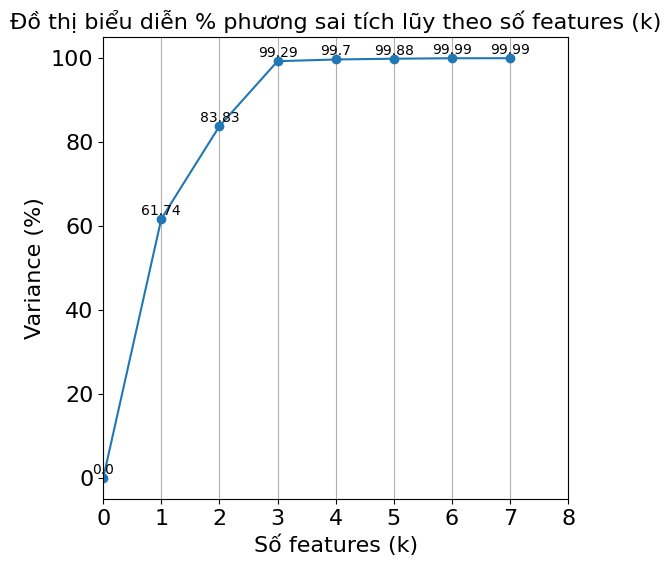

In [42]:
# # Vẽ đồ thị biểu diễn % phương sai tích lũy theo số features --> chọn k theo điểm "gẫy"
points = np.cumsum(pca.explained_variance_ratio_) * 100 # Các điểm dữ liệu
points = np.insert(points, 0, 0) # Thêm điểm k = 0, variance = 0
x_i = np.arange(0, 8)
y_i = (points[-8:])//0.01/100

plt.figure(figsize = (6,6))
plt.plot(points, marker = 'o')
plt.xlabel('Số features (k)',fontsize=16)
plt.ylabel('Variance (%)',fontsize=16)
plt.title('Đồ thị biểu diễn % phương sai tích lũy theo số features (k)',fontsize=16)
plt.xlim([0, nb_features + 1])
plt.grid(axis = 'x')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
for i in x_i:
    plt.text(i, y_i[i]+1, y_i[i], ha = 'center', va = 'baseline') # tung độ của text cao hơn point 1 đơn vị

plt.savefig('figs/variance-ratio.pdf')
plt.show()
# #%: tổng phương sai của k cột/ tổng phương sai của tất cả các cột

In [43]:
## Kiểm chứng: Tính phương sai tích lũy theo giá trị của k
var = 0.0
for k in range(1, nb_features + 1):
    pca = PCA(k)
    pca.fit(df)

    newVar = pca.explained_variance_ratio_.sum() * 100
    print('   * k = %2d' %k, ': phương sai tích lũy ~ %.2f%%' %newVar,
          '--> tăng ~ %.2f%%' %(newVar - var))
    var = newVar

   * k =  1 : phương sai tích lũy ~ 61.75% --> tăng ~ 61.75%
   * k =  2 : phương sai tích lũy ~ 83.83% --> tăng ~ 22.09%
   * k =  3 : phương sai tích lũy ~ 99.30% --> tăng ~ 15.47%
   * k =  4 : phương sai tích lũy ~ 99.70% --> tăng ~ 0.40%
   * k =  5 : phương sai tích lũy ~ 99.88% --> tăng ~ 0.18%
   * k =  6 : phương sai tích lũy ~ 99.99% --> tăng ~ 0.11%
   * k =  7 : phương sai tích lũy ~ 100.00% --> tăng ~ 0.01%


In [44]:
pca = PCA(n_components = 3)
pca.fit(df)

PCA(n_components=3)

In [45]:
X=pca.transform(df)

In [46]:
print('PCA.Components:\n', pca.components_)
print('PCA.Shape: ', pca.components_.shape)
print('PCA.Explained variance: ', pca.explained_variance_)
print('PCA.Explained variance shape: ', pca.explained_variance_.shape)

PCA.Components:
 [[ 3.81650706e-06 -8.33507983e-02 -9.96224138e-01 -2.27328438e-02
  -4.38932580e-04 -7.33153465e-03 -4.40280503e-03]
 [-4.21574185e-04 -5.01027071e-02 -1.85746108e-02  9.98564087e-01
  -3.11186582e-03 -1.94201589e-03 -9.13704797e-04]
 [ 1.69998832e-04  9.95117142e-01 -8.44879969e-02  4.83784455e-02
  -4.07173748e-03  1.53441951e-02  3.33547771e-03]]
PCA.Shape:  (3, 7)
PCA.Explained variance:  [2145.95008673  767.56565423  537.53629357]
PCA.Explained variance shape:  (3,)


##Mean Shift

### Chọn bandwidth dựa trên biểu diễn kết quả phân cụm

In [47]:
%load_ext autotime

time: 4.97 ms (started: 2024-03-03 11:58:59 +00:00)


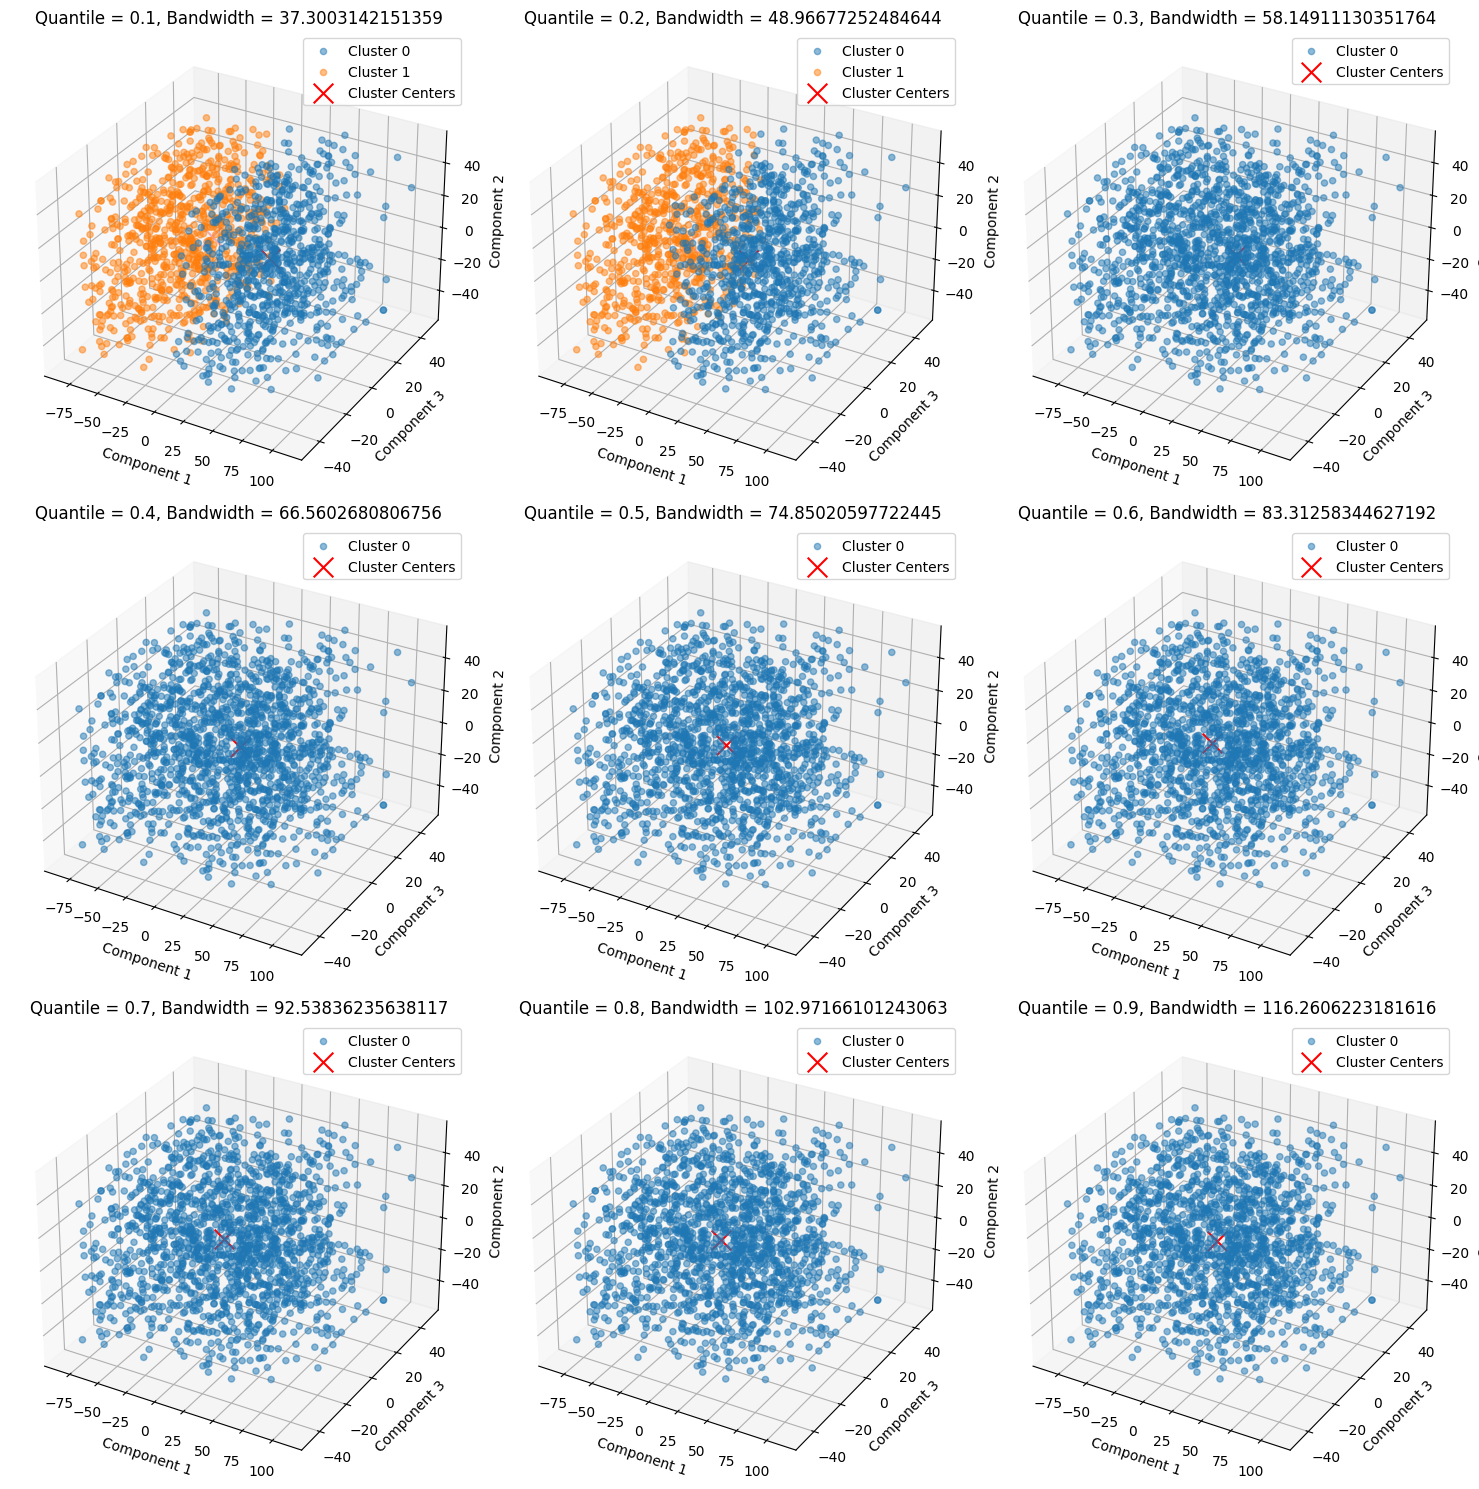

time: 2min 5s (started: 2024-03-03 11:58:59 +00:00)


In [48]:
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

fig, axes = plt.subplots(3, 3, figsize=(15, 15), subplot_kw={'projection': '3d'})

# Lặp qua các giá trị quantile
for i, quant in enumerate(quantiles):
    bw = estimate_bandwidth(X, quantile=quant)

    # Áp dụng Mean Shift
    ms = MeanShift(bandwidth=bw)
    ms.fit(X)
    labels = ms.labels_
    cluster_centers = ms.cluster_centers_

    # Biểu diễn scatter plot 3D
    ax = axes[i // 3, i % 3]

    # Biểu diễn từng điểm dữ liệu theo nhóm
    for cluster_label in np.unique(labels):
        cluster_points = X[labels == cluster_label]
        ax.scatter(cluster_points[:, 0], cluster_points[:, 2], cluster_points[:, 1],
                   label=f'Cluster {cluster_label}', alpha=0.5)

    # Đánh dấu trung tâm cụm
    ax.scatter(cluster_centers[:, 0], cluster_centers[:, 2], cluster_centers[:, 1],
               marker='x', s=200, c='red', label='Cluster Centers')

    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 3')
    ax.set_zlabel('Component 2')
    ax.set_title(f'Quantile = {quant}, Bandwidth = {bw}')
    ax.legend()

plt.tight_layout()
plt.savefig('figs/ms-quantile.pdf')
plt.show()

###Chọn bandwidth dựa trên phương pháp Grid Search

In [49]:
from sklearn.cluster import MeanShift
from sklearn.metrics import silhouette_score
from sklearn.model_selection import GridSearchCV

bw_list=[]
for quant in quantiles:
  bw =estimate_bandwidth(X,quantile = quant)
  bw_list.append(bw)

meanshift = MeanShift(bandwidth=estimate_bandwidth(X, quantile=0.2), bin_seeding=True)

# Định nghĩa tham số grid search
param_grid = {'bandwidth': bw_list}

grid_search = GridSearchCV(meanshift, param_grid, scoring=silhouette_score)
grid_search.fit(X)

best_model = grid_search.best_estimator_

labels = best_model.predict(X)
best_model = grid_search.best_estimator_
best_params = grid_search.best_params_
silhouette_avg = silhouette_score(X, labels)

print("Best Params:", best_params)
print("Avg Score - Silhouette Score:", silhouette_avg)

Best Params: {'bandwidth': 37.3003142151359}
Avg Score - Silhouette Score: 0.3695521952867357
time: 12.9 s (started: 2024-03-03 12:01:05 +00:00)


### Biểu diễn kết quả phân cụm dưới dạng 2D

In [50]:
ms = MeanShift(bandwidth = estimate_bandwidth(X,quantile = 0.1))
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print(f"Số cụm : {n_clusters_}")

Số cụm : 2
time: 17.4 s (started: 2024-03-03 12:01:18 +00:00)


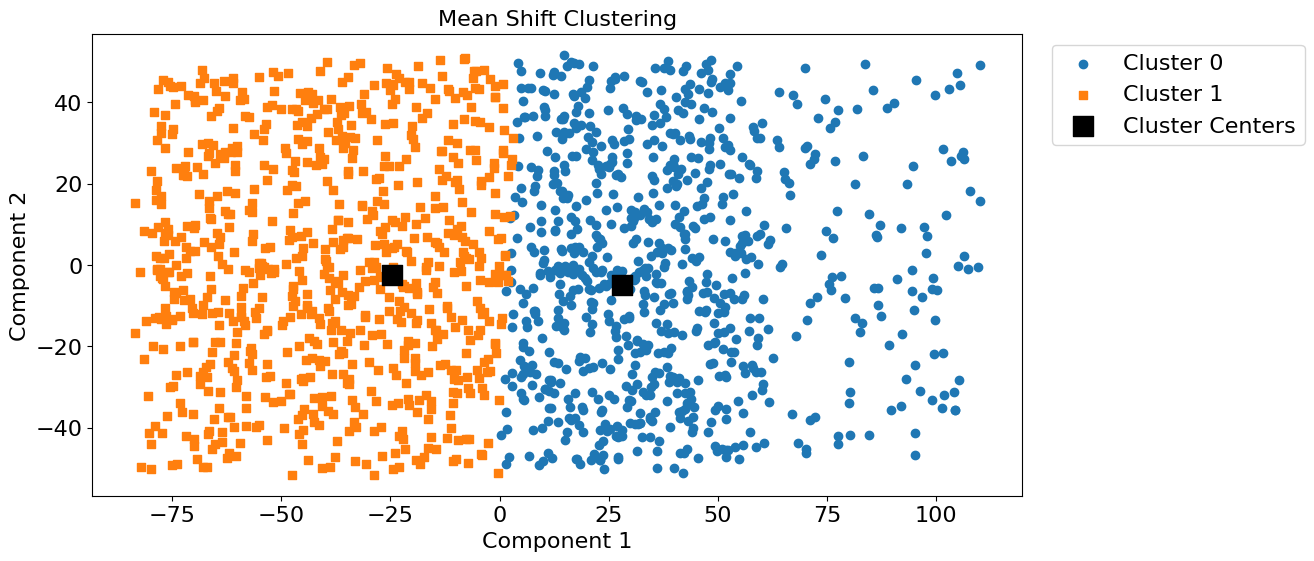

time: 494 ms (started: 2024-03-03 12:01:35 +00:00)


In [51]:
plt.figure(figsize=(12, 6))

markers = ['o', 's', '^', '*']

for cluster_label, marker in zip(range(n_clusters_), markers):
    cluster_points = X[labels == cluster_label]
    plt.scatter(
        cluster_points[:, 0],
        cluster_points[:, 1],
        label=f'Cluster {cluster_label}',
        marker=marker,
    )

plt.scatter(
    cluster_centers[:, 0],
    cluster_centers[:, 1],
    color='black',
    marker=marker,
    s=200,
    label='Cluster Centers',
)

plt.xlabel('Component 1', fontsize=16)
plt.ylabel('Component 2', fontsize=16)
plt.title('Mean Shift Clustering', fontsize=16)
plt.savefig('figs/cluster_result_1.pdf')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.legend(fontsize=16, bbox_to_anchor=(1.02, 1), loc='upper left')
plt.show()

In [52]:
# from sklearn.cluster import MeanShift
# from sklearn.model_selection import GridSearchCV
# from sklearn.metrics import silhouette_score
# from sklearn.cluster import estimate_bandwidth

# bandwidth = estimate_bandwidth(X, quantile=0.2, n_samples=100)
# param_grid = {'bandwidth': [bandwidth, bandwidth * 1.5, bandwidth * 2.0]}
# meanshift = MeanShift(bin_seeding=True)
# grid_search = GridSearchCV(meanshift, param_grid, scoring='neg_mean_squared_error', cv=5)
# grid_search.fit(X)
# # best estimator
# best_model = grid_search.best_estimator_

# # labels of the best model
# labels = best_model.predict(X)
# best_model = grid_search.best_estimator_
# best_params = grid_search.best_params_
# silhouette_avg = silhouette_score(X, labels)

# print("Best Params:", best_params)
# print("Avg Score - Silhouette Score:", silhouette_avg)

time: 400 µs (started: 2024-03-03 12:01:36 +00:00)


##Đánh giá mô hình

###ELBOW

In [53]:
bandwidth = [float(i) for i in list(range(36,50))]
scores = []
labels_list = []
for i, b in enumerate(bandwidth):
    ms2 = MeanShift(bandwidth=b, bin_seeding=True)
    ms2.fit(X)
    labels_list.append(ms2.labels_)
    scores.append(silhouette_score(X, labels_list[i]))

time: 9.22 s (started: 2024-03-03 12:01:36 +00:00)


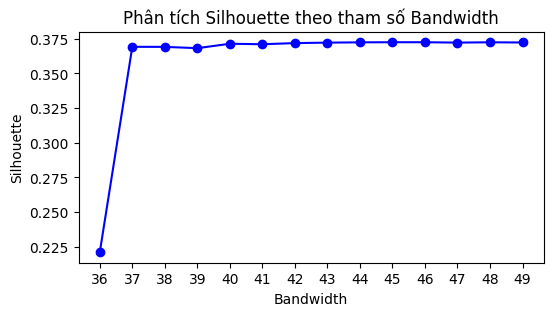

time: 591 ms (started: 2024-03-03 12:01:45 +00:00)


In [54]:
##  Biểu diễn trực quan Inertia --> xác định elbow
plt.figure(figsize = (6, 3))
plt.plot(bandwidth, scores, 'bo-')
plt.xlabel('Bandwidth')
plt.xticks(bandwidth)
plt.ylabel('Silhouette')
plt.title('Phân tích Silhouette theo tham số Bandwidth')
plt.savefig('figs/elbow_bandwidth.pdf')
plt.show()

In [55]:
# để so sánh thời gian

ms = MeanShift(bandwidth = 48.603)
ms.fit(X)
labels = ms.labels_
cluster_centers = ms.cluster_centers_

labels_unique = np.unique(labels)
n_clusters_ = len(labels_unique)

print(f"Số cụm : {n_clusters_}")

Số cụm : 2
time: 15.2 s (started: 2024-03-03 12:01:45 +00:00)


###Biểu đồ Silhouette

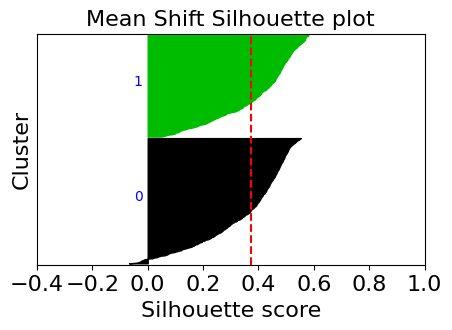

time: 377 ms (started: 2024-03-03 12:02:01 +00:00)


In [56]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
# Silhouette trung bình cho tất cả samples
silhouette_avg = silhouette_score(X, labels)

# Silhouette scores cho mỗi sample (data point) xi
silhouettes_samples = silhouette_samples(X, labels)

plt.figure(figsize = (5, 3))
# Silhouette plot
plt.xlim([silhouette_avg, 1])
plt.ylim([0, len(X) + (n_clusters_ + 1) * 10])
plt.title('Mean Shift Silhouette plot',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Silhouette score',fontsize=16)
plt.ylabel('Cluster',fontsize=16)
# Vạch đứng đứt nét thể hiện Silouette trung bình
plt.axvline(x = silhouette_avg, color = 'red', linestyle = '--')

plt.xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.yticks([])  # Xóa ticks trên trục tung

# Vẽ silhouette scores cho từng cluster Ci
y_lower = 10 # tung độ bắt đầu vẽ
for Ci in range(n_clusters_):
    # Silhouette scores của các samples trong cluster Ci (sắp xếp giảm dần)
    silhouette_Ci = silhouettes_samples[labels == Ci]
    silhouette_Ci.sort()

    size_Ci = silhouette_Ci.shape[0]
    y_upper = y_lower + size_Ci # tung độ kết thúc của Ci

    # Vẽ các đường ngang thể hiện silhouette scores của Ci
    color = cm.nipy_spectral(float(Ci) / n_clusters_) # phổ mầu
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, silhouette_Ci,
                      facecolor = color, edgecolor = color)

    # Hiện label của cluster Ci ở phía bên trái
    plt.text(-0.05, y_lower + 0.5 * size_Ci, str(Ci), color = 'blue')
    # plt.suptitle(f'***** k = {k} *****', fontsize = 14, fontweight = 'bold')

    # Tung độ cho cluster kế tiếp
    y_lower = y_upper + 10  # 10 là độ cách
plt.savefig('figs/ms-plot.pdf')
plt.show()

## So sánh với các thuật toán khác

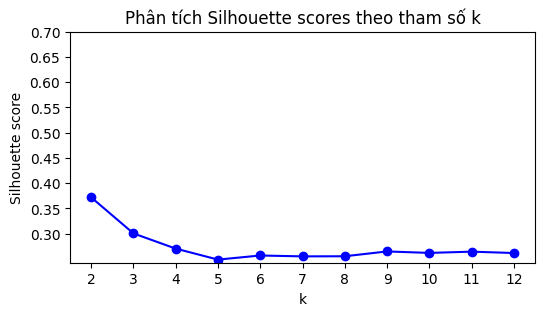

Giá trị tối ưu cho tham số: k = 2
time: 2.7 s (started: 2024-03-03 12:02:01 +00:00)


In [57]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

## Phân tích Silhouette scores theo giá trị của tham số k
nbClusters  = range(2, 13) # Lưu ý: (k >= 2) vì cần tính khoảng cách từ xi đến nearest cluster
silhouettes = []
for k in nbClusters:
    model = KMeans(n_clusters = k)
    model.fit(X)
    silhouettes.append(silhouette_score(X, model.fit_predict(X), metric = 'euclidean'))

plt.figure(figsize = (6, 3))
plt.plot(nbClusters, silhouettes, 'bo-')
plt.xlabel('k')
plt.xticks(nbClusters)
plt.ylabel('Silhouette score')
plt.yticks(np.arange(0.3, 0.75, 0.05))
plt.title('Phân tích Silhouette scores theo tham số k')

plt.show()
print(f'Giá trị tối ưu cho tham số: k = {nbClusters[np.argmax(silhouettes)]}')

In [58]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

k = 2
kmeans = KMeans(n_clusters=k, random_state=0)
kmeans.fit(X)

labels = kmeans.labels_
cluster_centers = kmeans.cluster_centers_

silhouette_avg = silhouette_score(X, labels)

print(f"Number of clusters: {k}")
print(f"Silhouette Score: {silhouette_avg}")

Number of clusters: 2
Silhouette Score: 0.37207197272166703
time: 345 ms (started: 2024-03-03 12:02:04 +00:00)


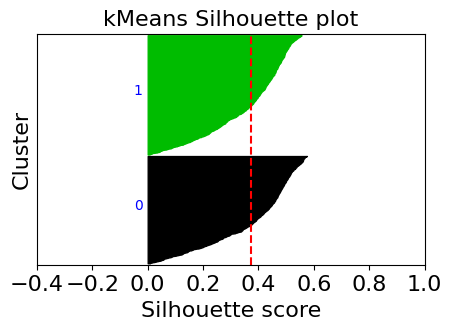

time: 725 ms (started: 2024-03-03 12:02:04 +00:00)


In [59]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
# Silhouette trung bình cho tất cả samples
silhouette_avg = silhouette_score(X, labels)

# Silhouette scores cho mỗi sample (data point) xi
silhouettes_samples = silhouette_samples(X, labels)

plt.figure(figsize = (5, 3))
# Silhouette plot
plt.xlim([silhouette_avg, 1])
plt.ylim([0, len(X) + (n_clusters_ + 1) * 10])
plt.title('kMeans Silhouette plot',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Silhouette score',fontsize=16)
plt.ylabel('Cluster',fontsize=16)

# Vạch đứng đứt nét thể hiện Silouette trung bình
plt.axvline(x = silhouette_avg, color = 'red', linestyle = '--')

plt.xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.yticks([])  # Xóa ticks trên trục tung

# Vẽ silhouette scores cho từng cluster Ci
y_lower = 10 # tung độ bắt đầu vẽ
for Ci in range(n_clusters_):
    # Silhouette scores của các samples trong cluster Ci (sắp xếp giảm dần)
    silhouette_Ci = silhouettes_samples[labels == Ci]
    silhouette_Ci.sort()

    size_Ci = silhouette_Ci.shape[0]
    y_upper = y_lower + size_Ci # tung độ kết thúc của Ci

    # Vẽ các đường ngang thể hiện silhouette scores của Ci
    color = cm.nipy_spectral(float(Ci) / n_clusters_) # phổ mầu
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, silhouette_Ci,
                      facecolor = color, edgecolor = color)

    # Hiện label của cluster Ci ở phía bên trái
    plt.text(-0.05, y_lower + 0.5 * size_Ci, str(Ci), color = 'blue')
    # plt.suptitle(f'***** k = {k} *****', fontsize = 14, fontweight = 'bold')

    # Tung độ cho cluster kế tiếp
    y_lower = y_upper + 10  # 10 là độ cách

plt.savefig('figs/kmeans-plot.pdf')
plt.show()

In [60]:
from sklearn.cluster import AgglomerativeClustering

n_clusters = 2
hac = AgglomerativeClustering(n_clusters=n_clusters)

hac.fit(X)
labels = hac.labels_

silhouette_avg = silhouette_score(X, labels)
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.34578791976551415
time: 128 ms (started: 2024-03-03 12:02:05 +00:00)


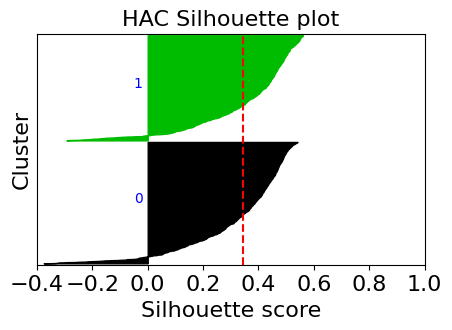

time: 358 ms (started: 2024-03-03 12:02:05 +00:00)


In [61]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
# Silhouette trung bình cho tất cả samples
silhouette_avg = silhouette_score(X, labels)

# Silhouette scores cho mỗi sample (data point) xi
silhouettes_samples = silhouette_samples(X, labels)

plt.figure(figsize = (5, 3))
# Silhouette plot
plt.xlim([silhouette_avg, 1])
plt.ylim([0, len(X) + (n_clusters_ + 1) * 10])
plt.title('HAC Silhouette plot',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Silhouette score',fontsize=16)
plt.ylabel('Cluster',fontsize=16)

# Vạch đứng đứt nét thể hiện Silouette trung bình
plt.axvline(x = silhouette_avg, color = 'red', linestyle = '--')

plt.xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.yticks([])  # Xóa ticks trên trục tung

# Vẽ silhouette scores cho từng cluster Ci
y_lower = 10 # tung độ bắt đầu vẽ
for Ci in range(n_clusters_):
    # Silhouette scores của các samples trong cluster Ci (sắp xếp giảm dần)
    silhouette_Ci = silhouettes_samples[labels == Ci]
    silhouette_Ci.sort()

    size_Ci = silhouette_Ci.shape[0]
    y_upper = y_lower + size_Ci # tung độ kết thúc của Ci

    # Vẽ các đường ngang thể hiện silhouette scores của Ci
    color = cm.nipy_spectral(float(Ci) / n_clusters_) # phổ mầu
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, silhouette_Ci,
                      facecolor = color, edgecolor = color)

    # Hiện label của cluster Ci ở phía bên trái
    plt.text(-0.05, y_lower + 0.5 * size_Ci, str(Ci), color = 'blue')
    # plt.suptitle(f'***** k = {k} *****', fontsize = 14, fontweight = 'bold')

    # Tung độ cho cluster kế tiếp
    y_lower = y_upper + 10  # 10 là độ cách

plt.savefig('figs/hac-plot.pdf')
plt.show()

In [62]:
from sklearn.cluster import Birch

birch = Birch(threshold=0.5, n_clusters=2)

birch.fit(X)

labels = birch.labels_

silhouette_avg = silhouette_score(X, labels)

print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.34578791976551415
time: 211 ms (started: 2024-03-03 12:02:05 +00:00)


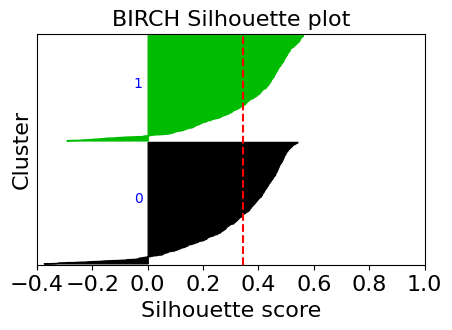

time: 395 ms (started: 2024-03-03 12:02:06 +00:00)


In [63]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
# Silhouette trung bình cho tất cả samples
silhouette_avg = silhouette_score(X, labels)

# Silhouette scores cho mỗi sample (data point) xi
silhouettes_samples = silhouette_samples(X, labels)

plt.figure(figsize = (5, 3))
# Silhouette plot
plt.xlim([silhouette_avg, 1])
plt.ylim([0, len(X) + (n_clusters_ + 1) * 10])
plt.title('BIRCH Silhouette plot',fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Silhouette score',fontsize=16)
plt.ylabel('Cluster',fontsize=16)

# Vạch đứng đứt nét thể hiện Silouette trung bình
plt.axvline(x = silhouette_avg, color = 'red', linestyle = '--')

plt.xticks([-0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])
plt.yticks([])  # Xóa ticks trên trục tung

# Vẽ silhouette scores cho từng cluster Ci
y_lower = 10 # tung độ bắt đầu vẽ
for Ci in range(n_clusters_):
    # Silhouette scores của các samples trong cluster Ci (sắp xếp giảm dần)
    silhouette_Ci = silhouettes_samples[labels == Ci]
    silhouette_Ci.sort()

    size_Ci = silhouette_Ci.shape[0]
    y_upper = y_lower + size_Ci # tung độ kết thúc của Ci

    # Vẽ các đường ngang thể hiện silhouette scores của Ci
    color = cm.nipy_spectral(float(Ci) / n_clusters_) # phổ mầu
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, silhouette_Ci,
                      facecolor = color, edgecolor = color)

    # Hiện label của cluster Ci ở phía bên trái
    plt.text(-0.05, y_lower + 0.5 * size_Ci, str(Ci), color = 'blue')
    # plt.suptitle(f'***** k = {k} *****', fontsize = 14, fontweight = 'bold')

    # Tung độ cho cluster kế tiếp
    y_lower = y_upper + 10  # 10 là độ cách
plt.savefig('figs/birch-plot.pdf')
plt.show()

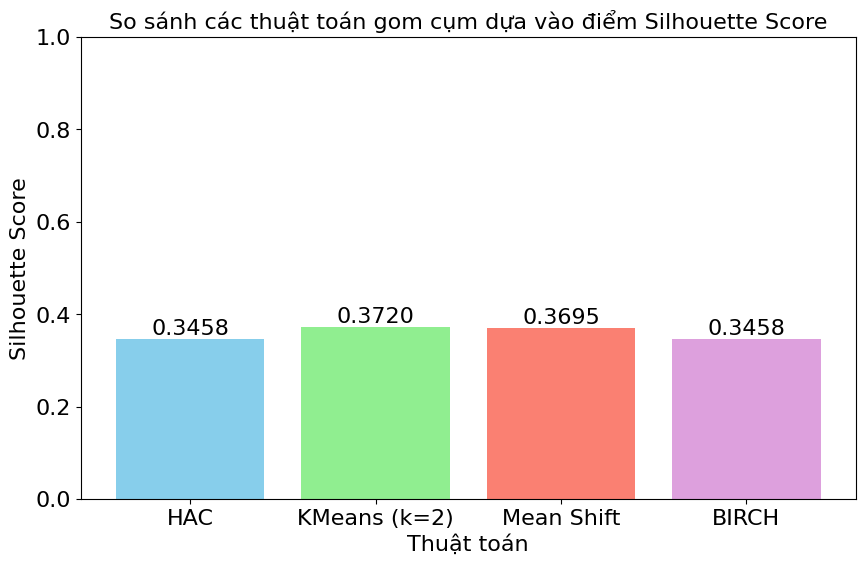

time: 400 ms (started: 2024-03-03 12:02:06 +00:00)


In [64]:
silhouette_scores = {
    'HAC': 0.3458,
    'KMeans (k=2)': 0.3720,
    'Mean Shift': 0.3695,
    'BIRCH': 0.3458
}

algorithms = list(silhouette_scores.keys())
scores = [silhouette_scores[algorithm] for algorithm in algorithms]

plt.figure(figsize=(10, 6))
plt.bar(algorithms, scores, color=['skyblue', 'lightgreen', 'salmon', 'plum'])
plt.xlabel('Thuật toán', fontsize=16)
plt.ylabel('Silhouette Score', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.title('So sánh các thuật toán gom cụm dựa vào điểm Silhouette Score', fontsize=16)
plt.ylim(0, 1)

for i, score in enumerate(scores):
    plt.text(i, score + 0.01, f'{score:.4f}', ha='center', fontsize=16)

plt.savefig('figs/comparison.pdf')
plt.show()

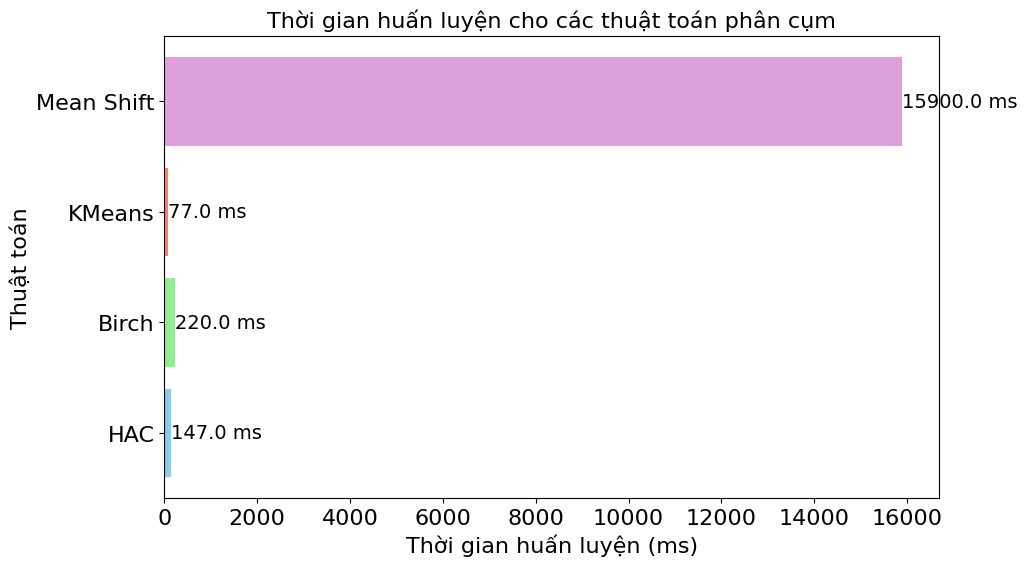

time: 371 ms (started: 2024-03-03 12:02:07 +00:00)


In [65]:
'''
hac:147 ms
Birch:220ms
kmeans: 77 ms
mean shift: 15.9 s 16.1 s
'''

algorithms = ['HAC', 'Birch', 'KMeans', 'Mean Shift']
execution_times = [147, 220, 77, 15.9 * 1000]
colors = ['skyblue', 'lightgreen', 'salmon', 'plum']

plt.figure(figsize=(10, 6))
bars = plt.barh(algorithms, execution_times, color=colors)

plt.xlabel('Thời gian huấn luyện (ms)', fontsize=16)
plt.ylabel('Thuật toán', fontsize=16)
plt.title('Thời gian huấn luyện cho các thuật toán phân cụm', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
             f'{bar.get_width():.1f} ms',
             va='center', fontsize=14)

plt.savefig('figs/time-comparision.pdf')
plt.show()

# **REFERENCES**

1. https://scikit-learn.org/stable/auto_examples/cluster/plot_mean_shift.html#sphx-glr-auto-examples-cluster-plot-mean-shift-py